In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import rioxarray as rxr
from datetime import datetime
import glob
import os
import contextily as ctx
import xarray
from collections import Counter
import cmcrameri.cm as cmc
import shutil

from working_sca_funcs import *

In [2]:
# Define year you are working on
year = '2022'

# Define basin you are working on
# name = 'DLNY'
name = 'BUDD'

# Define model you are working on
# model = 'V5' # 2022 BUDD ASO 2 class
# model = 'V7' # 2022 BUDD manual classification snow/no snow trained on set of images and artifacts on different images
model = 'V9'

# raw PS images
ps_raw = f'/data0/images/planet/emma/planet/{name}/'
# ps_raw_subdir = sorted([d for d in glob.glob(ps_raw + str(year) + '*') if os.path.isdir(d)])
ps_raw_subdir = sorted([d for d in glob.glob(ps_raw + '*') if os.path.isdir(d)])

# SCA directory
ps_sca_dir = f'/home/etboud/projects/data/rerun/{name}/{model}/'
# ps_sca_tif = glob.glob(ps_sca_dir + f'*{year}*.tif')
ps_sca_tif = glob.glob(ps_sca_dir + '*.tif')

# ASO directory
aso_dir = f'/home/etboud/projects/data/aso/validation/{name}/V2/'
# aso_tif = glob.glob(os.path.join(aso_dir, f'*{year}*3m*.tif')) 
aso_tif = glob.glob(os.path.join(aso_dir, '*3m*.tif'))

# Create basin shapefile
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
basin = gpd.read_file(BS)
basin = basin.to_crs('EPSG:32611') 

# Extract dates from file names
ps_dates = extract_dates([], ps_sca_tif)[1]  
aso_dates = extract_dates(aso_tif, [])[0]

# canopy height model
CHM = '/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif'

In [3]:
corr_fn = '/home/etboud/projects/ps_sca/corresponding_files.csv'
corr_df = pd.read_csv(corr_fn)

In [ ]:
results_df_list = []
for index, row in corr_df.iterrows():
    ps_evaluation = row['model_file']
    aso_validation = row['aso_file']  
    name = ps_evaluation.split('/')[-3]
    basin = gpd.read_file(f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson')
    basin = basin.to_crs('EPSG:32611')
    validation_df = create_validation_dataset(ps_evaluation, aso_validation, basin)
    validation_df = validation_df.dropna()
    metrics_df = calculate_metrics(validation_df)
    metrics_df['basin'] = name
    metrics_df['model'] = ps_evaluation.split('/')[-2]
    metrics_df['year'] = ps_evaluation.split('/')[-1][:4]
    metrics_df['eval_file'] = os.path.basename(ps_evaluation)
    metrics_df['val_file'] = os.path.basename(aso_validation)
    # Append the results to the list
    results_df_list.append(metrics_df)
    
# Concatenate all the DataFrames into a single DataFrame
results_df = pd.concat(results_df_list, ignore_index=True)
    

In [4]:
results_fn = '/home/etboud/projects/ps_sca/validation_results.csv'
results_df = pd.read_csv(results_fn)

In [19]:
results_df

,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,FP,FN,basin,model,year,eval_file,val_file
0,0.921940,0.347801,0.505066,0.347801,0.674915,0.511358,0.374971,-0.015984,512796,90141,43418,961600,DLNY,V7,2022,20220405_174728_SCA.tif,ASO_Tuolumne_2022Apr05_snowdepth_3m_binary.tif
1,0.958388,0.601812,0.739353,0.601812,0.811699,0.706755,0.627388,0.146122,861710,161278,37414,570150,DLNY,V7,2022,20220429_183504_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
2,0.781460,0.433960,0.558033,0.433960,0.929043,0.681502,0.746378,0.376303,293911,1076175,82194,383366,DLNY,V7,2022,20220519_181733_SCA.tif,ASO_Tuolumne_2022May18_snowdepth_3m_binary.tif
3,0.990229,0.818249,0.896062,0.818249,0.156549,0.487399,0.811975,0.012172,1260192,2308,12435,279916,DLNY,V7,2023,20230426_174658_SCA.tif,ASO_Tuolumne_2023Apr27_snowdepth_3m_binary.tif
4,0.960946,0.521583,0.676159,0.521583,0.603785,0.562684,0.525757,0.024606,928792,57522,37747,851927,DLNY,V7,2023,20230601_175109_SCA.tif,ASO_Tuolumne_2023Jun01-02_snowdepth_3m_binary.tif
5,0.965293,0.398123,0.563739,0.398123,0.961450,0.679786,0.550659,0.240098,547125,490624,19672,827136,DLNY,V7,2023,20230629_175448_SCA.tif,ASO_Tuolumne_2023Jun26-27_snowdepth_3m_binary.tif
6,0.927632,0.630138,0.750478,0.630138,0.400382,0.515260,0.612729,0.018484,430028,22401,33548,252407,BUDD,V7,2022,20220403_174654_SCA.tif,ASO_Tuolumne_2022Apr05_snowdepth_3m_binary.tif
7,0.971143,0.717148,0.825039,0.717148,0.618911,0.668029,0.711946,0.092506,526003,25384,15630,207462,BUDD,V7,2022,20220430_181902_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
8,0.858694,0.645550,0.737021,0.645550,0.839196,0.742373,0.722586,0.428902,314038,269695,51678,172428,BUDD,V7,2022,20220518_182210_SCA.tif,ASO_Tuolumne_2022May18_snowdepth_3m_binary.tif
9,0.978894,0.810970,0.887055,0.810970,0.411974,0.611472,0.799448,0.047143,590829,8925,12739,137717,BUDD,V7,2023,20230426_174533_SCA.tif,ASO_Tuolumne_2023Apr27_snowdepth_3m_binary.tif


In [35]:
select = results_df[(results_df['val_file']=='ASO_Tuolumne_2023Jun26-27_snowdepth_3m_binary.tif')]

In [93]:
select

,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,FP,FN,basin,model,year,eval_file,val_file
1,0.958388,0.601812,0.739353,0.601812,0.811699,0.706755,0.627388,0.146122,861710,161278,37414,570150,DLNY,V7,2022,20220429_183504_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
7,0.971143,0.717148,0.825039,0.717148,0.618911,0.668029,0.711946,0.092506,526003,25384,15630,207462,BUDD,V7,2022,20220430_181902_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
14,0.949355,0.596302,0.732507,0.596302,0.805931,0.701117,0.625824,0.206437,965633,213924,51513,653735,DLNY,V5,2022,20220429_183504_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
20,0.975288,0.811295,0.885765,0.811295,0.686792,0.749043,0.803627,0.226727,634695,35264,16082,147628,BUDD,V5,2022,20220430_181902_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
27,0.942962,0.831668,0.883825,0.831668,0.693095,0.762382,0.812153,0.403350,1346777,183973,81464,272591,DLNY,V9,2022,20220429_183504_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif
33,0.966640,0.930816,0.948390,0.930816,0.510556,0.720686,0.904932,0.349243,728199,26215,25131,54124,BUDD,V9,2022,20220430_181902_SCA.tif,ASO_Tuolumne_2022Apr29_snowdepth_3m_binary.tif


In [36]:
select.drop(columns=['val_file','eval_file','year','TP','TN','FP','FN','sensitivity','kappa','balanced_accuracy','specificity'], inplace=True)

/tmp/ipykernel_2506272/1904322856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select.drop(columns=['val_file','eval_file','year','TP','TN','FP','FN','sensitivity','kappa','balanced_accuracy','specificity'], inplace=True)


In [95]:
select

,precision,recall,f1,accuracy,basin,model
1,0.958388,0.601812,0.739353,0.627388,DLNY,V7
7,0.971143,0.717148,0.825039,0.711946,BUDD,V7
14,0.949355,0.596302,0.732507,0.625824,DLNY,V5
20,0.975288,0.811295,0.885765,0.803627,BUDD,V5
27,0.942962,0.831668,0.883825,0.812153,DLNY,V9
33,0.966640,0.930816,0.948390,0.904932,BUDD,V9


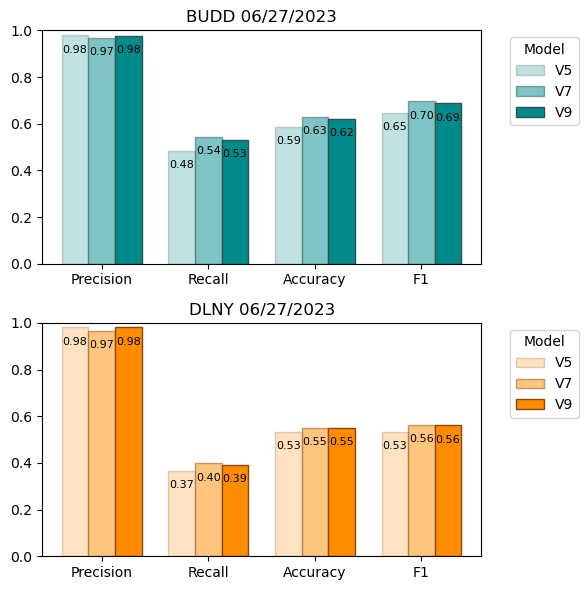

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Split the data for each basin
budd_data = select[select['basin'] == 'BUDD']
dlny_data = select[select['basin'] == 'DLNY']

# Set up the subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Define metrics and bar width
metrics = ['precision', 'recall', 'accuracy','f1']
bar_width = 0.25
x = np.arange(len(metrics))  # the label locations

# Define colors and transparency
tint = [0.25, 0.5, 1]  # transparency levels

# Plot BUDD data with offsets for each model
for i, model in enumerate(['V5', 'V7', 'V9']):
    values = budd_data[budd_data['model'] == model][metrics].values[0]
    bars = axes[0].bar(x + i * bar_width, values, width=bar_width, color='darkcyan', alpha=tint[i], label=model, edgecolor='darkslategrey')
    
    # Add value labels on top of each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height-.04, f'{height:.2f}', ha='center', va='top', fontsize=8)

axes[0].set_title('BUDD 06/27/2023')
axes[0].set_xticks(x + bar_width)  # Set position for x-axis labels
axes[0].set_xticklabels(['Precision', 'Recall', 'Accuracy','F1'])
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside to the top right
axes[0].set_ylim(0, 1)

# Plot DLNY data with offsets for each model
for i, model in enumerate(['V5', 'V7', 'V9']):
    values = dlny_data[dlny_data['model'] == model][metrics].values[0]
    bars = axes[1].bar(x + i * bar_width, values, width=bar_width, color='darkorange', alpha=tint[i], label=model, edgecolor='saddlebrown')
    
    # Add value labels on top of each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width() / 2, height-.04, f'{height:.2f}', ha='center', va='top', fontsize=8)

axes[1].set_title('DLNY 06/27/2023')
axes[1].set_xticks(x + bar_width)  # Set position for x-axis labels
axes[1].set_xticklabels(['Precision', 'Recall', 'Accuracy','F1'])
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside to the top right
axes[1].set_ylim(0, 1)

# Show the plots
plt.tight_layout()
plt.show()


## Looking at canopy vs no canopy

In [5]:
# creating canopy mask
# canopy height model
ref_file = f'/data0/images/planet/emma/planet/{name}/' + '20230423_175100_99_242e/a514a5df-5610-45c4-8498-a774361cb492/PSScene/20230423_175100_99_242e_3B_AnalyticMS_SR_clip.tif' # BUDD
CHM = '/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif'
chm_mask, mean, max, fcan = create_binary_chm(CHM, basin)
ref_file = rxr.open_rasterio(ref_file).rio.clip(basin.geometry)
open_ref = ref_file.copy()
open_ref.values = np.where(chm_mask[0], open_ref, 0)
canop_ref = ref_file - open_ref
canop_ref.attrs = open_ref.attrs
canop_ref.rio.set_nodata(0)


open_mask = open_ref.values
open_mask = np.sum(open_mask, axis=0)
open_ref = open_ref.isel(band=0)
open_ref.values = open_mask
# Create a canopy reference where 0 replaces open

canop_mask = canop_ref.values
canop_mask = np.sum(canop_mask, axis=0)
canop_ref = canop_ref.isel(band=0)
canop_ref.values = canop_mask

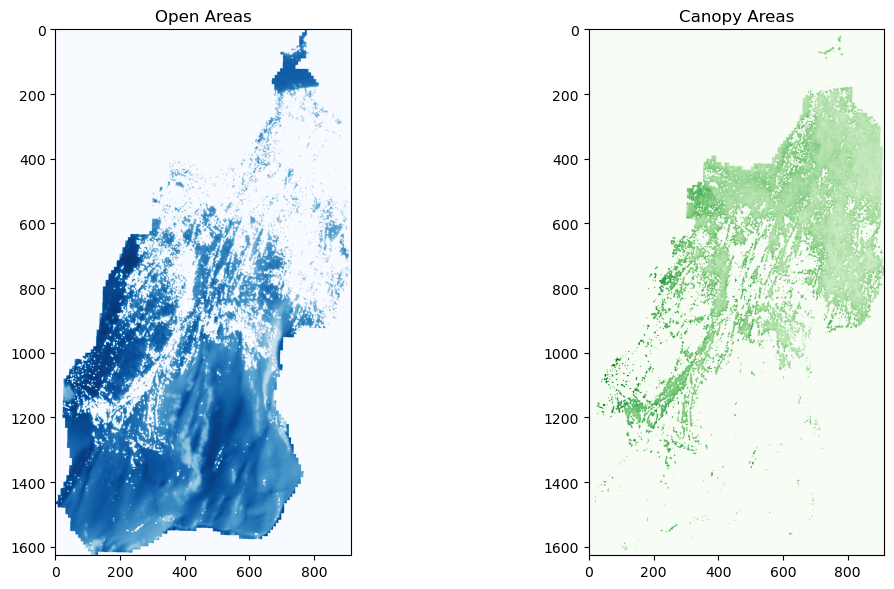

In [38]:
import matplotlib.pyplot as plt

# Visualize canopy and open areas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Open mask (use .values to access the underlying array)
axes[0].imshow(open_ref.values, cmap='Blues')
axes[0].set_title('Open Areas')

# Canopy mask (use .values to access the underlying array)
axes[1].imshow(canop_ref.values, cmap='Greens')
axes[1].set_title('Canopy Areas')

plt.tight_layout()
plt.show()


In [6]:
def process_raster(raster_tif, basin,rgi_mask,wbd_mask,mask):
    with rioxarray.open_rasterio(raster_tif) as src:
        src.values = np.where(np.isnan(src.values),0,src.values)
        src = src.rio.clip(basin.geometry)
        src = src.rio.clip(rgi_mask.geometry, invert = True)
        src = src.rio.clip(wbd_mask.geometry, invert = True)
        mask_bool = mask>0
        masked_src = src.where(mask_bool)
        masked_src = masked_src.rio.set_nodata(0)
        
        points = []
        height, width = masked_src.shape[1], masked_src.shape[2]

        # Iterate over pixel coordinates and gather PS values
        for y in range(height):
            for x in range(width):
                if mask_bool[y, x]:  # Only take points where mask is True (open areas)
                    points.append((x, y, masked_src.values[0, y, x]))
    return pd.DataFrame(points, columns=['x', 'y', 'value'])        


def create_validation_dataset(ps_tif, aso_tif, basin, mask):
    # Read RGI and WBD shapefiles
    rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
    rgi_mask = gpd.read_file(rgi).to_crs('EPSG:32611')
    wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
    wbd_mask = gpd.read_file(wbd).to_crs('EPSG:32611')

    # Process PS and ASO rasters with the canopy/open mask and debug visualization
    ps_df = process_raster(ps_tif, basin, rgi_mask, wbd_mask, mask)
    ps_df.rename(columns={'value': 'predict'}, inplace=True)

    aso_df = process_raster(aso_tif, basin, rgi_mask, wbd_mask, mask)
    aso_df.rename(columns={'value': 'obs'}, inplace=True)

    # Merge the dataframes on the pixel coordinates
    df = pd.merge(aso_df, ps_df, on=['x', 'y'])
    
    return df    


In [7]:
results_open_list = []
# test on first 5 of itterrows
for index, row in corr_df.iterrows():
    ps_evaluation = row['model_file']
    aso_validation = row['aso_file']  
    name = ps_evaluation.split('/')[-3]
    basin = gpd.read_file(f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson')
    basin = basin.to_crs('EPSG:32611')
    validation_df = create_validation_dataset(ps_evaluation, aso_validation, basin, open_ref)
    validation_df = validation_df.dropna()
    metrics_df = calculate_metrics(validation_df)
    metrics_df['basin'] = name
    metrics_df['model'] = ps_evaluation.split('/')[-2]
    metrics_df['year'] = ps_evaluation.split('/')[-1][:4]
    metrics_df['eval_file'] = os.path.basename(ps_evaluation)
    metrics_df['val_file'] = os.path.basename(aso_validation)
    # Append the results to the list
    results_open_list.append(metrics_df)
    
# Concatenate all the DataFrames into a single DataFrame
results_df = pd.concat(results_open_list, ignore_index=True)

KeyboardInterrupt: 

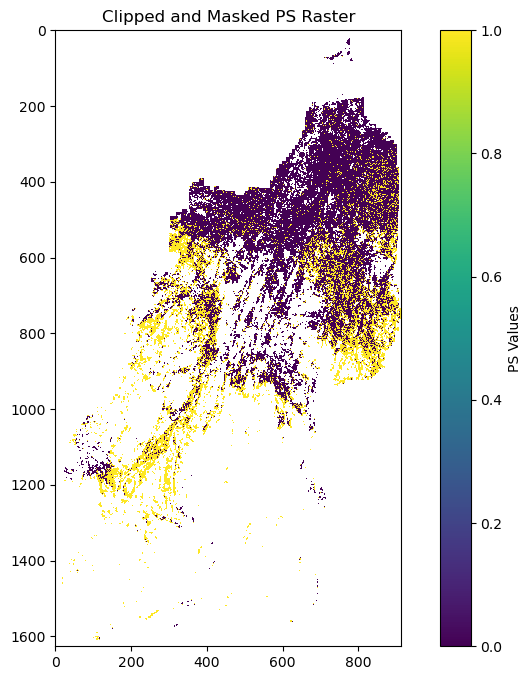

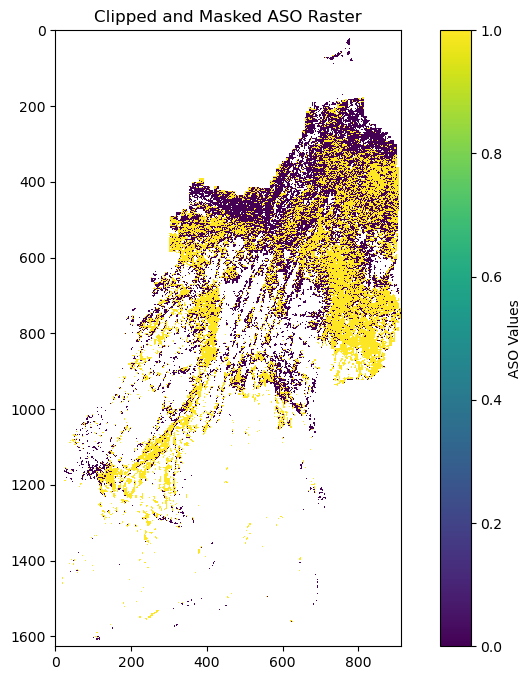

In [ ]:
# # Testing on one corresponding date
# name='BUDD'
# model = 'V5'
# ps_tif = f'/home/etboud/projects/data/rerun/{name}/{model}/20220518_182210_SCA.tif'
# aso_tif = f'/home/etboud/projects/data/aso/validation/{name}/V2/ASO_Tuolumne_2022May18_snowdepth_3m_binary.tif'
# 
# # Mask out the RGI and WBD Testing
# rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
# rgi_mask = gpd.read_file(rgi).to_crs('EPSG:32611')
# wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
# wbd_mask = gpd.read_file(wbd).to_crs('EPSG:32611')


# # Open and clip the PS raster dataset
# with rioxarray.open_rasterio(ps_tif, masked=True) as ds:
#     ds.values = np.where(np.isnan(ds.values), 0, ds.values)  # Replace NaN with 0
#     ds_clipped = ds.rio.clip(basin.geometry)
#     ds_clipped = ds_clipped.rio.clip(rgi_mask.geometry, invert=True)
#     ds_clipped = ds_clipped.rio.clip(wbd_mask.geometry, invert=True)
    
#     # Apply the mask for open areas (mask > 0 means 'open')
#     mask_bool = canop_ref > 0  # Ensure the mask is binary
#     masked_ps = ds_clipped.where(mask_bool)  # Keep only the 'open' areas

#     # Set NoData for non-masked areas
#     masked_ps = masked_ps.rio.set_nodata(0)

#     # Plot the clipped and masked PS raster
#     plt.figure(figsize=(10, 8))
#     plt.imshow(masked_ps.isel(band=0), cmap='viridis', interpolation='none')    
#     plt.colorbar(label='PS Values')
#     plt.title('Clipped and Masked PS Raster')
#     plt.show()
    
#     # Prepare PS data points for dataframe
#     ps_points = []
#     height, width = masked_ps.shape[1], masked_ps.shape[2]

#     # Iterate over pixel coordinates and gather PS values
#     for y in range(height):
#         for x in range(width):
#             if mask_bool[y, x]:  # Only take points where mask is True (open areas)
#                 ps_points.append((x, y, masked_ps.values[0, y, x]))

# # Create dataframe for PS data
# ps_df = pd.DataFrame(ps_points, columns=['x', 'y', 'predict'])


# # Open and clip the ASO raster dataset
# with rioxarray.open_rasterio(aso_tif, masked=True) as ds:
#     ds.values = np.where(np.isnan(ds.values), 0, ds.values)  # Replace NaN with 0
#     ds_clipped = ds.rio.clip(basin.geometry, drop=False)
#     ds_clipped = ds_clipped.rio.clip(rgi_mask.geometry, invert=True)
#     ds_clipped = ds_clipped.rio.clip(wbd_mask.geometry, invert=True)

#     # Apply the mask for open areas (mask > 0 means 'open')
#     mask_bool = canop_ref > 0  # Ensure the mask is binary
#     masked_aso = ds_clipped.where(mask_bool)  # Keep only the 'open' areas
#     # Set NoData for non-masked areas
#     masked_ps = masked_aso.rio.set_nodata(0)

#     # Plot the clipped and masked ASO raster
#     plt.figure(figsize=(10, 8))
#     plt.imshow(masked_aso.isel(band=0), cmap='viridis', interpolation='none')
#     plt.colorbar(label='ASO Values')
#     plt.title('Clipped and Masked ASO Raster')
#     plt.show()

#     # Initialize aso_points list
#     aso_points = []
#     height, width = masked_aso.shape[1], masked_aso.shape[2]

#     # Iterate over pixel coordinates and gather ASO values
#     for y in range(height):
#         for x in range(width):
#             if mask_bool[y, x]:  # Only take points where mask is True (open areas)
#                 aso_points.append((x, y, masked_aso.values[0, y, x]))

# # Create dataframe for ASO data
# aso_df = pd.DataFrame(aso_points, columns=['x', 'y', 'obs'])

# # Merge the two dataframes on the pixel coordinates
# df = pd.merge(aso_df, ps_df, on=['x', 'y'])    